



#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 2개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 설치

In [ ]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

#### 2) 형태소 분석을 위한 라이브러리

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
#깃허브에서 KoBERT 파일 로드
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-0wrfi003/kobert-tokenizer_a5962048114e4b95ab6d416776809217
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-0wrfi003/kobert-tokenizer_a5962048114e4b95ab6d416776809217
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=110eea47e2e1a3309eebe04130031c9c86ec9c134438fe4560407f3a4e374adf
  Stored in directory: /tmp/pip-ephem-wheel-cache-gjee5xxx/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
import torch
import random
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

# ★ Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# !pip install mecab

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, GlobalMaxPooling1D
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

* 형태소 분석을 위한 함수를 제공합니다.

In [ ]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [ ]:
# 형태소 분석을 수행하는 함수

def tokenize(original_sent, tokenizer_name='okt', nouns=False):
    # 불용어 정의
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
        tokens = [word for word in tokens if not word in stopwords] # 불용어 제거

    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ex : path = '/content/drive/MyDrive/project/'
path = '/content/drive/MyDrive/2023.10.30_미니프로젝트6차_실습자료 및 데이터/데이터'

#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [ ]:
train = joblib.load(os.path.join(path, 'train.pkl'))
test = joblib.load(os.path.join(path, 'test.pkl'))

# okt로 질문을 형태소 분석한 결과가 데이터 프레임에 담긴 상태
clean_train = joblib.load(os.path.join(path, 'clean_train.pkl'))
clean_test = joblib.load(os.path.join(path, 'clean_test.pkl'))

* KoBERT

In [ ]:
train.head()

,intent,Q,A,type,Q_len,Q_remove_sc
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,16,떨어뜨려서 핸드폰 액정 나갔어
1,1,액정 나갔어,as 맡기세요.,0,6,액정 나갔어
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0,16,핸드폰 떨어뜨려서 고장 났나봐
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,13,노트북 키보드가 안먹히네
5,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,13,노트북 전원이 안들어와


In [ ]:
train.Q_len.max()

127

In [ ]:
test.Q_len.max()

41

In [ ]:
train.intent = train.intent-1
test.intent = test.intent-1

In [ ]:
train_data = []
test_data = []
for q, label in zip(train['Q'], train['intent']) :
    data = []
    data.append(q)
    data.append(str(label))

    train_data.append(data)

for q, label in zip(test['Q'], test['intent']) :
    data = []
    data.append(q)
    data.append(str(label))

    test_data.append(data)

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

# # CPU 사용
# device = torch.device("cpu")

#BERT 모델, Vocabulary 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 35
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tok = tokenizer.tokenize

data_train = BERTDataset(train_data, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(test_data, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(train.intent.unique())

53

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=53,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
KoBERT = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in KoBERT.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in KoBERT.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    KoBERT.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = KoBERT(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(KoBERT.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    KoBERT.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = KoBERT(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/19 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1815905570983887 train acc 0.953125
epoch 1 train acc 0.9819078947368421


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 1 test acc 0.8318452380952381


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.1959789991378784 train acc 0.96875
epoch 2 train acc 0.9827302631578947


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 2 test acc 0.8199404761904762


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.1271358728408813 train acc 0.96875
epoch 3 train acc 0.9893092105263158


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 3 test acc 0.8318452380952381


* 모델 저장하기

In [ ]:
test_acc = 0.0
KoBERT.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = KoBERT(token_ids, valid_length, segment_ids)
    test_acc += calc_accuracy(out, label)
print("epoch {} test acc {}".format(1, test_acc / (batch_id+1)))

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 1 test acc 0.8318452380952381


In [ ]:
def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    KoBERT.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = KoBERT(token_ids, valid_length, segment_ids)

        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()
            intent = np.argmax(logits)
            ans = random.choice(train.loc[train['intent']==intent, 'A'].unique())

        print(ans)

    return intent

In [ ]:
#학습된 KOBERT 모델 kobert로 저장하기
joblib.dump(KoBERT, 'kobert.pkl')

['kobert.pkl']

In [ ]:
#학습된 KOBERT모델 불러오기
KoBERT = joblib.load('/content/drive/MyDrive/2023.10.30_미니프로젝트6차_실습자료 및 데이터/데이터/kobert.pkl')

### (3) 챗봇 구축

# 챗봇1
* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [ ]:
input = '아직 대학 졸업예정인데, 지원 가능한가요?'

In [ ]:
# 분류 모델을 이용하여 intent 예측
predict(input)

KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.
단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.
또한 전공의 종류와는 무관 합니다.


In [ ]:
input2 = '비전공자도 가능한가요?'
predict(input2)

비전공자도 SW개발에 관심과 열정이 있으신 분들은 충분히 따라 갈 수 있습니다. 이 경우 데이터 사이언스 기반으로 산업 현장에 AI를 접목하고 DX를 이끄는 DX컨설턴트 Track을 추천 드립니다. SW기초 지식 및 코딩역량을 보유하고 있고 개발자로 성장하고 싶은 분께는 AI개발자 Track을 추천 드립니다. 파이썬 프로그래밍 사용법과 AI 개념에 대한 기초 이해를 공부하고 오시면 도움이 되실 것 같습니다.


In [ ]:
input3 = '배고프다'
predict(input3)

힘들겠어요.


#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [ ]:
def get_answer1(question):
    intent = predict(question)
    return

In [ ]:
get_answer1('교육 듣다가 중도포기 가능한가요?')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


교육 등록신청을 하지 않거나 교육 일정 시작 전에 교육 등록을 취소해도 지원자격에 해당하는 경우 다시 지원이 가능합니다.
다만, 교육 과정 확정자신고일(교육시작일로부터 7일)이 지난 후 중도 퇴교를 할 경우 과정을 수강한 것으로 간주되며, 향후 K-Digital Training (K-DT) 과정에 재지원은 가능하나 무료 수강은 어렵습니다.


33

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [ ]:
test_data[1]

['핸드폰 맛이 갔어', '0']

In [ ]:
cnt=0
for _, intent in enumerate(test_data):
    print("질문:", intent[0], "\n대답:", end=' ')
    intent_pred = get_answer1(intent[0])
    if int(intent[1])==intent_pred:
        cnt+=1
    print()

질문: 노트북이 작동이 안되네 
대답: as 맡기세요.

질문: 핸드폰 맛이 갔어 
대답: 교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.

원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. 
- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB

질문: 내 의지는 상관없나봐 
대답: KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.
단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.
또한 전공의 종류와는 무관 합니다.

질문: 올해 취업하길 
대답: 가장 중요한 거예요.

질문: 추워죽겠다 
대답: 감기 조심하세요.

질문: 바람 많이 부네 
대답: 감기 조심하세요.

질문: 나들이를 가볼까 
대답: 같이 가보세요.

질문: 바다 가자고 하면 갈까? 
대답: 같이 가자고 말해보세요

질문: mmm 
대답: 교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있으므로, 제공한 노트북을 사용해 주시기 바랍니다.

원활한 실습 환경을 위해 아래 명시된 사양 이상을 갖춘 노트북을 제공합니다. 
- CPU : I5 / RAM : 8GB / 여유저장공간 : 40GB

질문: 불면증 온 거 같아. 
대답: 고민이 많은가 봐요.

질문: 공부 시작해도 될까 
대답: 공부가 최우선이죠.

질문: 새로운 공부 시작해도 될까 
대답: 공부는 끝이 없죠.

질문: 친구가 내 뒷담 깠어 
대답: 너무 신경쓰지마세요.

질문: 나를 친구로 생각 안했나봐 
대답: 그런 친구 말고 제대로 된 친구 사귀세요.

질문: 단발로 자를까 
대답: 힘들겠네요.

질문: 계속 열심히 공부하는데 집중이 잘 안되네 
대답: 비전공자도 SW개발에 관심과 열정이 있으신 분들은 충분히 따라 갈 수 있습니다.  
이 경우 데이터 사이언스 기반으로 산업 현장에 

In [ ]:
print(cnt/len(test_data))

0.8018867924528302


In [ ]:
get_answer1("수료 직후 취업 가능?")

KT 에이블스쿨은 미래인재육성 + 청년 IT/SW/DX 분야 일자리 창출을 위해서 KT 와 정부가 함께 하는 프로그램입니다.  
에이블러 여러분들의 취업기회를 위해 Job Searching 세션, 취업컨설팅, 잡페어 등 여러 프로그램들을 운영하고 있습니다.

KT 직접채용은 그 일환 중 하나이며, KT에 합격한 1기 수료생의 경우 해당지역에 배치되었습니다.  
KT 외에 KT 그룹사, 주요 협력사, AI원팀 기업, 스타트업 등의 채용은 지역 구분 없이 진행됩니다. 
채용 상황에 따라 변경될 수 있어 교육 수료 후 채용 연계 시 상세 안내 드리겠습니다. 

KT 그룹, AI 원팀 기업/스타트업 100 등 다양한 기업에서 채용 연계할 예정으로 기업마다 인재상 및 반영 요소가 다르기 때문에 중점 요소에 대해 안내드리기 어려운 점 양해 부탁드립니다. 채용에 대한 부분은 교육을 참여하시면 추후 관련 부서를 통해 안내드릴 예정입니다.


In [ ]:
get_answer1("취업하고 싶어요")

저도요.


In [ ]:
get_answer1("이거 하고 취업 못하면 책임 져요?")

KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가능합니다.
미취업자의 기준은 아래와 같습니다.
1) 기간의 정함이 있는 근로인 경우
2) 고용보험에 미가입한 경우
3) 고용보험에 가입되어 있더라도 15시간/주 미만 근로인 경우
단, 어떠한 경우에도 교육을 풀타임(09:00~18:00)으로 들을 수 있어야 교육 참여가 가능합니다. 

프리랜서 계약의 경우, 고용보험에 가입하지 않은 경우 미취업자로 보지만, 개인별 상황이 다를 수 있어서 관할 고용센터에 문의하여 확인하시기 바랍니다. 
또한 현재 군 복무 중인 상태여도 지원 가능하며, 교육 시작 전일까지 병역 의무를 마쳐야 교육 수강이 가능합니다. 

퇴사 후 고용보험 상실이 완료되어 실업급여를 수급 중인 경우, 훈련 수강에는 문제가 없습니다.
다만, 실업급여와 훈련장려금은 중복 수급이 불가하여 실업급여 지급이 종료된 후 훈련장려금 지급이 개시됩니다.


# 챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
            * Embedding + LSTM 모델
        * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [ ]:
clean_train[:10]

0           떨어뜨려서 핸드폰 액정 나갔어
1                     액정 나갔어
2          핸드폰 떨어뜨려서 고장 났나 봐
4           노트북 키 보드 가 안 먹히네
5             노트북 전원 이 안 들어와
6      노트북 을 떨어뜨려서 고장 난 것 같아
7        컴퓨터 가 제대로 작동 하지 않아요
8     컴퓨터 가 에러 메시지 를 띄우고 있어요
9                 컴터 고장 났나 봐
10               컴터 가 맛 이 갔어
Name: Q_remove_sc, dtype: object

In [ ]:
train.Q

,intent,Q,A,type,Q_len,Q_remove_sc
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,16,떨어뜨려서 핸드폰 액정 나갔어
1,1,액정 나갔어,as 맡기세요.,0,6,액정 나갔어
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0,16,핸드폰 떨어뜨려서 고장 났나봐
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,13,노트북 키보드가 안먹히네
5,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,13,노트북 전원이 안들어와
...,...,...,...,...,...,...
1293,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,30,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요
1294,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,19,다른 교육과의 차이점은 무엇인가요
1295,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,16,다른 교육과 차이점이 있나요
1296,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,29,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요


In [ ]:
okt = Okt()

In [ ]:
if 'okt_morphs' not in globals():
    %time okt_morphs = train.Q.apply(lambda t:okt.morphs(str(t)))
    %time okt_nouns = train.Q.apply(lambda t:okt.nouns(str(t)))
    %time okt_pos = train.Q.apply(lambda t: okt.pos(str(t), norm = True, stem = True, join = True))

In [ ]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언..?

def okt_tokenizer(string):
    return list("/".join(res) for res in okt.pos(str(string)))

In [ ]:
%%time
TOP_K = 5000
MAX_SEQUENCE_LEN=25 #embedding size

# 토큰 형태로 제작
clean_tr = train.Q.apply(lambda x: okt_tokenizer(x))
clean_te = test.Q.apply(lambda x: okt_tokenizer(x))

# .fit_on_texts 이용하여 토크나이저 만들기
tokenizer = Tokenizer(num_words = TOP_K, char_level = False)
tokenizer.fit_on_texts(clean_tr)

CPU times: user 4.08 s, sys: 8.52 ms, total: 4.09 s
Wall time: 4.64 s


In [ ]:
clean_tr[5]

['노트북/Noun', '전원/Noun', '이/Josa', '안/VerbPrefix', '들어와/Verb', './Punctuation']

In [ ]:
# 전체 토큰의 수 확인
tokenizer.num_words

5000

In [ ]:
tokenizer.word_index

In [ ]:
# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
clean_tr_seq = tokenizer.texts_to_sequences(clean_tr)
clean_te_seq = tokenizer.texts_to_sequences(clean_te)

max_len = len(max(clean_tr_seq, key=len))
if max_len > MAX_SEQUENCE_LEN:
    max_len = MAX_SEQUENCE_LEN

print(max_len)

# <PAD> 는 0으로 추가
clean_tr_seq_str = sequence.pad_sequences(clean_tr_seq, maxlen=max_len)
clean_te_seq_str = sequence.pad_sequences(clean_te_seq, maxlen=max_len)

25


In [ ]:
# 전체 토큰의 수가 vocab 사이즈가 됨

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행

In [ ]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
dictionary = tokenizer.word_index

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

,count,mean,std,min,25%,50%,75%,max
Q,1192.0,7.733221,4.490793,1.0,5.0,7.0,10.0,50.0


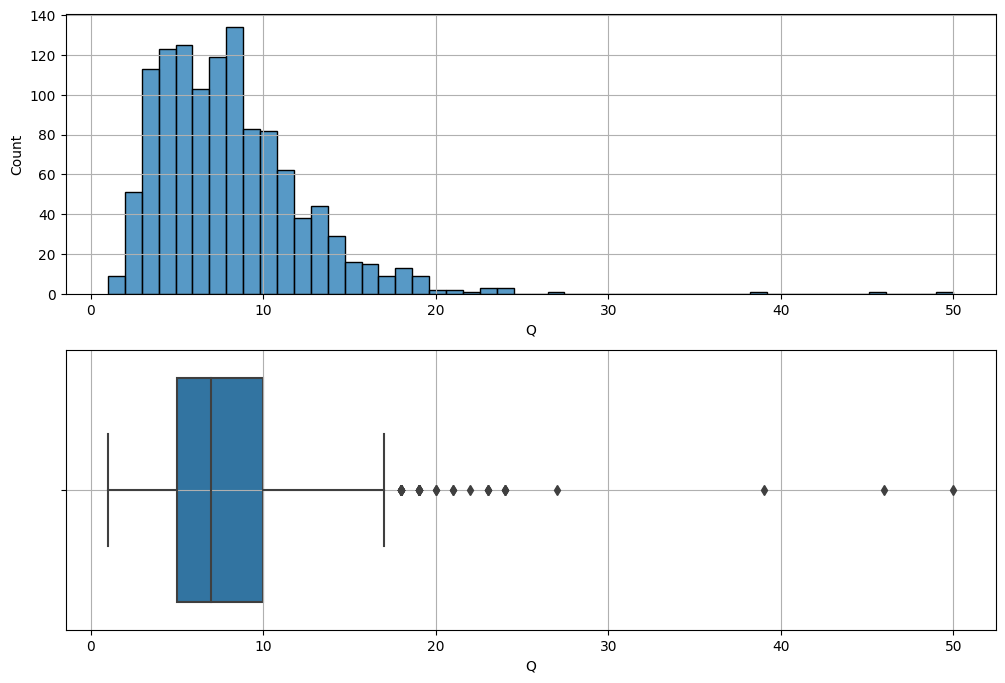

In [ ]:
# 문장별 토큰 수 카운트

# 기초 통계량

# 분포 그래프

train_word_counts = clean_tr.apply(lambda x: len(x))
display(pd.DataFrame(train_word_counts).describe().T)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.histplot(train_word_counts, bins=50)
plt.grid()

plt.subplot(2, 1, 2)
sns.boxplot(x = train_word_counts)
plt.grid()
plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다.

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [ ]:
okt = Okt()

def okt_tokenizer(string):
    return list("/".join(res) for res in okt.pos(str(string)))


TOP_K = 5000
MAX_SEQUENCE_LEN=25 #embedding size

clean_tr = train.Q.apply(lambda x: okt_tokenizer(x))
clean_te = test.Q.apply(lambda x: okt_tokenizer(x))

tokenizer_lstm = Tokenizer(num_words = TOP_K, char_level = False)
tokenizer_lstm.fit_on_texts(clean_tr)

clean_tr_seq = tokenizer_lstm.texts_to_sequences(clean_tr)
clean_te_seq = tokenizer_lstm.texts_to_sequences(clean_te)

max_len = len(max(clean_tr_seq, key=len))
if max_len > MAX_SEQUENCE_LEN:
    max_len = MAX_SEQUENCE_LEN

print(max_len)

# <PAD> 는 0으로 추가
clean_tr_seq_str = sequence.pad_sequences(clean_tr_seq, maxlen=max_len)
clean_te_seq_str = sequence.pad_sequences(clean_te_seq, maxlen=max_len)



25


In [ ]:
def lstm_preprocessing(tokenizer, string):
    max_len = 25
    tr = okt_tokenizer(string)
    print(tr)
    tr_seq = tokenizer.texts_to_sequences(tr)
    tr_seq_pad = sequence.pad_sequences(tr_seq, maxlen=max_len)
    return tr_seq_pad

In [ ]:
lstm_preprocessing(tokenizer_lstm, "에이블스쿨 할만 한가요?")

['에이/Noun', '블/Noun', '스쿨/Noun', '할만/Verb', '한/Determiner', '가요/Noun', '?/Punctuation']


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]], dtype=int32)

In [ ]:
y_train = train['type']
y_test = test['type']

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

def make_lstm():
    lstm = tf.keras.Sequential([
        Embedding(clean_tr_seq_str.max()+1, 25),
        Dropout(0.25),

        LSTM(25, return_sequences=True),
        Dropout(0.25),
        GlobalMaxPooling1D(),

        Dense(2, activation='sigmoid'),
    ])

    lstm.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )

    lstm.fit(clean_tr_seq_str, y_train, epochs=10,
        validation_data=(clean_te_seq_str, y_test),
    )
    return lstm

lstm = make_lstm()

Epoch 1/10
38/38 [==============================] - 24s 235ms/step - loss: 0.6680 - accuracy: 0.6258 - val_loss: 0.6819 - val_accuracy: 0.4340
Epoch 2/10
38/38 [==============================] - 5s 139ms/step - loss: 0.4957 - accuracy: 0.6258 - val_loss: 0.5053 - val_accuracy: 0.4340
Epoch 3/10
38/38 [==============================] - 2s 61ms/step - loss: 0.3244 - accuracy: 0.8339 - val_loss: 0.4110 - val_accuracy: 0.9340
Epoch 4/10
38/38 [==============================] - 2s 49ms/step - loss: 0.2342 - accuracy: 0.9916 - val_loss: 0.2798 - val_accuracy: 0.9906
Epoch 5/10
38/38 [==============================] - 2s 38ms/step - loss: 0.1152 - accuracy: 0.9958 - val_loss: 0.1458 - val_accuracy: 0.9906
Epoch 6/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0677 - accuracy: 0.9966 - val_loss: 0.1224 - val_accuracy: 0.9906
Epoch 7/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0436 - accuracy: 0.9966 - val_loss: 0.0843 - val_accuracy: 1.0000
Epoch 8/10

In [ ]:
y_train = train['type']
y_test = test['type']

In [ ]:
y_train = to_categorical(y_train)

In [ ]:
y_test = to_categorical(y_test)

In [ ]:
y_train.shape, y_test.shape

((1192, 2), (106, 2))

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [ ]:
lstm = tf.keras.Sequential([
    Embedding(clean_tr_seq_str.max()+1, 25),
    Dropout(0.25),

    LSTM(25, return_sequences=True),
    Dropout(0.25),
    GlobalMaxPooling1D(),

    Dense(2, activation='sigmoid'),
])

lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 25)          35975     
                                                                 
 dropout_10 (Dropout)        (None, None, 25)          0         
                                                                 
 lstm_5 (LSTM)               (None, None, 25)          5100      
                                                                 
 dropout_11 (Dropout)        (None, None, 25)          0         
                                                                 
 global_max_pooling1d_2 (Gl  (None, 25)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 2)                 52        
                                                      

In [ ]:
lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [ ]:
clean_tr_seq_str

array([[  0,   0,   0, ..., 107, 521, 522],
       [  0,   0,   0, ...,   0, 521, 522],
       [  0,   0,   0, ..., 327, 410, 196],
       ...,
       [  0,   0,   0, ...,   2,   3,   1],
       [  0,   0,   0, ...,   2, 231, 471],
       [  0,   0,   0, ...,   2,   3,   1]], dtype=int32)

In [ ]:
lstm.fit(clean_tr_seq_str, y_train, epochs=10,
        validation_data=(clean_te_seq_str, y_test),
        )

Epoch 1/10
38/38 [==============================] - 1s 37ms/step - loss: 0.5039 - accuracy: 0.6258 - val_loss: 0.5068 - val_accuracy: 0.4340
Epoch 2/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3292 - accuracy: 0.7466 - val_loss: 0.4173 - val_accuracy: 0.9906
Epoch 3/10
38/38 [==============================] - 1s 28ms/step - loss: 0.2602 - accuracy: 0.9866 - val_loss: 0.3366 - val_accuracy: 0.9906
Epoch 4/10
38/38 [==============================] - 1s 17ms/step - loss: 0.1762 - accuracy: 0.9933 - val_loss: 0.2186 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 17ms/step - loss: 0.1039 - accuracy: 0.9983 - val_loss: 0.1504 - val_accuracy: 0.9906
Epoch 6/10
38/38 [==============================] - 1s 18ms/step - loss: 0.0634 - accuracy: 0.9992 - val_loss: 0.1187 - val_accuracy: 0.9906
Epoch 7/10
38/38 [==============================] - 1s 17ms/step - loss: 0.0417 - accuracy: 1.0000 - val_loss: 0.0842 - val_accuracy: 0.9906
Epoch 8/10
38

In [ ]:
lstm.predict(clean_te_seq_str)[59]

4/4 [==============================] - 0s 10ms/step


array([0.967953  , 0.04763392], dtype=float32)